In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

sns.set_style('whitegrid')

In [2]:
# importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, count, date_format, to_date, year, unix_timestamp, round, avg, sum, hour, dayofweek, lit
from pyspark.sql.types import StructType, StructField, StringType, DecimalType, BooleanType, FloatType, DoubleType, TimestampType, IntegerType

In [3]:
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [4]:
!echo $SPARK_MASTER_ADDRESS

spark://notch308.ipoib.int.chpc.utah.edu:7078


In [5]:
!echo $SPARK_MASTER_OOD_ADDRESS
!echo $SPARK_WORKER1_OOD_ADDRESS
!echo $SPARK_WORKER2_OOD_ADDRESS

https://ondemand-class.chpc.utah.edu/rnode/notch308.ipoib.int.chpc.utah.edu/8082
https://ondemand-class.chpc.utah.edu/rnode/notch308.ipoib.int.chpc.utah.edu/8083
https://ondemand-class.chpc.utah.edu/rnode/notch309.ipoib.int.chpc.utah.edu/8082


In [6]:
from pyspark.sql import SparkSession
import os
spark = SparkSession.builder \
    .master(os.getenv('SPARK_MASTER_ADDRESS')) \
    .appName("Spark-application") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/31 22:32:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
directory_path = "data/"

# Get a list of all CSV files in the directory
csv_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".csv")]

In [8]:
# Read the first CSV file to create the initial DataFrame
objects = spark.read.csv(csv_files[0], header=True, inferSchema=True)

# Loop through the remaining CSV files and union them with the initial DataFrame
for file in csv_files[1:]:
    objects_temp = spark.read.csv(file, header=True, inferSchema=True)
    objects = objects.union(objects_temp)

# Show the merged DataFrame
objects.show()

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+------------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|           end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+------------------+------------------+-------------+
|0905B18B365C9D20| classic_bike|2023-01-28 09:18:10|2023-01-28 09:28:52|Hoboken Terminal ...|           HB101|       Hamilton Park|         JC009|40.73593758446329|-74.03030455112457|      40.727595966|     -74.044247311|       member|
|B4F0562B05CB5404|electric_bike|2023-01-23 20:10:12|2023

In [9]:
objects.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



In [10]:
null_counts_per_column = {}

# Iterate over each column and count null values
for column in objects.columns:
    null_count = objects.filter(col(column).isNull()).count()
    null_counts_per_column[column] = null_count

# Show the null counts for each column
for column, cnt in null_counts_per_column.items():
    print(f"Column '{column}': {cnt} null values")


Column 'ride_id': 0 null values
Column 'rideable_type': 0 null values
Column 'started_at': 0 null values
Column 'ended_at': 0 null values
Column 'start_station_name': 92 null values
Column 'start_station_id': 92 null values
Column 'end_station_name': 3615 null values
Column 'end_station_id': 3615 null values
Column 'start_lat': 0 null values
Column 'start_lng': 0 null values
Column 'end_lat': 991 null values
Column 'end_lng': 991 null values
Column 'member_casual': 0 null values


In [11]:
# Drop rows containing any null values
objects = objects.dropna()

In [12]:
null_counts_per_column = {}

# Iterate over each column and count null values
for column in objects.columns:
    null_count = objects.filter(col(column).isNull()).count()
    null_counts_per_column[column] = null_count

# Show the null counts for each column
for column, cnt in null_counts_per_column.items():
    print(f"Column '{column}': {cnt} null values")

Column 'ride_id': 0 null values
Column 'rideable_type': 0 null values
Column 'started_at': 0 null values
Column 'ended_at': 0 null values
Column 'start_station_name': 0 null values
Column 'start_station_id': 0 null values
Column 'end_station_name': 0 null values
Column 'end_station_id': 0 null values
Column 'start_lat': 0 null values
Column 'start_lng': 0 null values
Column 'end_lat': 0 null values
Column 'end_lng': 0 null values
Column 'member_casual': 0 null values


In [13]:
# Convert 'started_at' and 'ended_at' columns to timestamps
objects = objects.withColumn('started_at', unix_timestamp(col('started_at'), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
objects = objects.withColumn('ended_at', unix_timestamp(col('ended_at'), 'yyyy-MM-dd HH:mm:ss').cast("timestamp"))

# Calculate duration of each ride in seconds
objects = objects.withColumn('total_ride_duration_seconds', (col('ended_at').cast('long') - col('started_at').cast('long')))

objects.show()

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+------------------+------------------+-------------+---------------------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|           end_lat|           end_lng|member_casual|total_ride_duration_seconds|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+------------------+------------------+-------------+---------------------------+
|0905B18B365C9D20| classic_bike|2023-01-28 09:18:10|2023-01-28 09:28:52|Hoboken Terminal ...|           HB101|       Hamilton Park|         JC009|40.73593758446329|-74.03030455112457|      40.727595966|     -

In [14]:
objects.count()

1091490

In [15]:
# Filter records with less than 1 minute duration
short_duration_rides = objects.filter(col('total_ride_duration_seconds') < 60)
short_duration_rides.count()

24946

In [16]:
objects = objects.filter(col('total_ride_duration_seconds') >= 60)
objects.count()

1066544

# 1. Where do Citi Bikers ride? (Popular start and end stations)

In [17]:
# Group by start station name and count the number of rides
start_station_counts = objects.groupBy('start_station_name').count().orderBy('count', ascending=False)

# Group by end station name and count the number of rides
end_station_counts = objects.groupBy('end_station_name').count().orderBy('count', ascending=False)

# Show top start and end stations
start_station_counts.show(10)
end_station_counts.show(10)

+--------------------+-----+
|  start_station_name|count|
+--------------------+-----+
|       Grove St PATH|49887|
|Hoboken Terminal ...|47540|
|South Waterfront ...|32109|
|Hoboken Terminal ...|28555|
|City Hall - Washi...|26324|
|        Newport PATH|25502|
|       Hamilton Park|23481|
|Bergen Ave & Sip Ave|22774|
|        Newport Pkwy|22097|
|11 St & Washingto...|20464|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|    end_station_name|count|
+--------------------+-----+
|       Grove St PATH|56221|
|Hoboken Terminal ...|46451|
|South Waterfront ...|32405|
|Hoboken Terminal ...|29648|
|City Hall - Washi...|26584|
|        Newport PATH|25569|
|       Hamilton Park|23559|
|        Newport Pkwy|22212|
|Bergen Ave & Sip Ave|22177|
|11 St & Washingto...|20316|
+--------------------+-----+
only showing top 10 rows



# 2. When do they ride? (Distribution of rides by time of day)

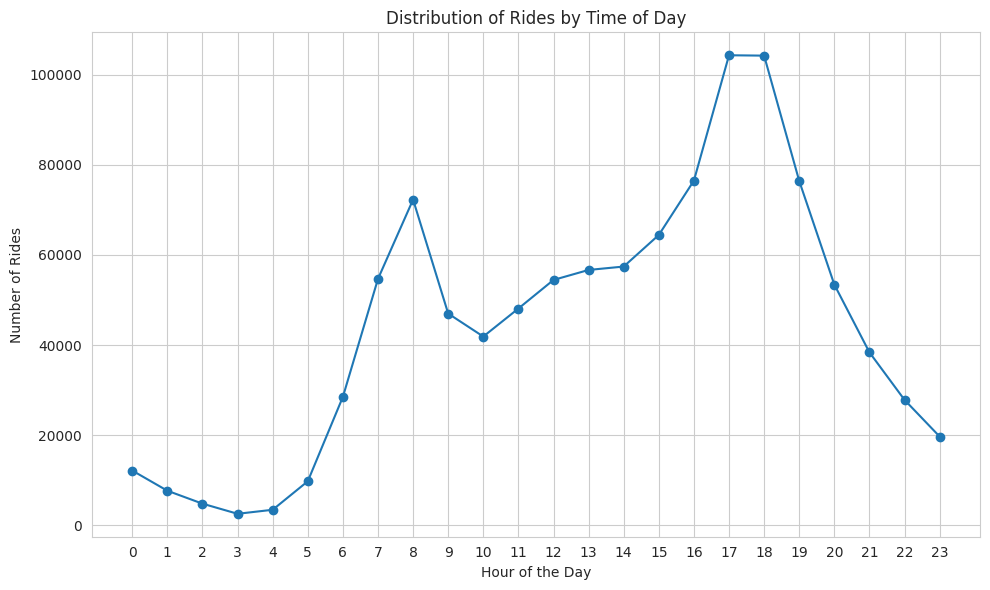

In [18]:
# Extract hour from the 'started_at' timestamp
objects = objects.withColumn('hour', hour('started_at'))

# Group by hour and count the number of rides
ride_hours = objects.groupBy('hour').count().orderBy('hour')

# Convert DataFrame to Pandas DataFrame for plotting
ride_hours_pd = ride_hours.toPandas()

# Plot distribution of rides by time of day
plt.figure(figsize=(10, 6))
plt.plot(ride_hours_pd['hour'], ride_hours_pd['count'], marker='o', linestyle='-')
plt.title('Distribution of Rides by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(24))  # Set x-axis ticks to show all hours of the day
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. How far do they go? (Average distance traveled per ride)

In [19]:
# Calculate distance traveled using start and end coordinates
objects = objects.withColumn('distance_km', lit(111.32) * (col('end_lat') - col('start_lat')) + lit(111.32) * (col('end_lng') - col('start_lng')) * col('end_lat'))

# Calculate average distance traveled per ride
average_distance = objects.agg({'distance_km': 'avg'}).collect()[0][0]

# Show average distance traveled per ride
print("Average distance traveled per ride:", average_distance, "km")

Average distance traveled per ride: 1.267777754303967 km


# 4. Which stations are most popular? (Top start and end stations)

In [20]:
# Show top start and end stations
start_station_counts.show(10)
end_station_counts.show(10)

+--------------------+-----+
|  start_station_name|count|
+--------------------+-----+
|       Grove St PATH|49887|
|Hoboken Terminal ...|47540|
|South Waterfront ...|32109|
|Hoboken Terminal ...|28555|
|City Hall - Washi...|26324|
|        Newport PATH|25502|
|       Hamilton Park|23481|
|Bergen Ave & Sip Ave|22774|
|        Newport Pkwy|22097|
|11 St & Washingto...|20464|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|    end_station_name|count|
+--------------------+-----+
|       Grove St PATH|56221|
|Hoboken Terminal ...|46451|
|South Waterfront ...|32405|
|Hoboken Terminal ...|29648|
|City Hall - Washi...|26584|
|        Newport PATH|25569|
|       Hamilton Park|23559|
|        Newport Pkwy|22212|
|Bergen Ave & Sip Ave|22177|
|11 St & Washingto...|20316|
+--------------------+-----+
only showing top 10 rows



# 5. What days of the week are most rides taken on? (Distribution of rides by day of the week)

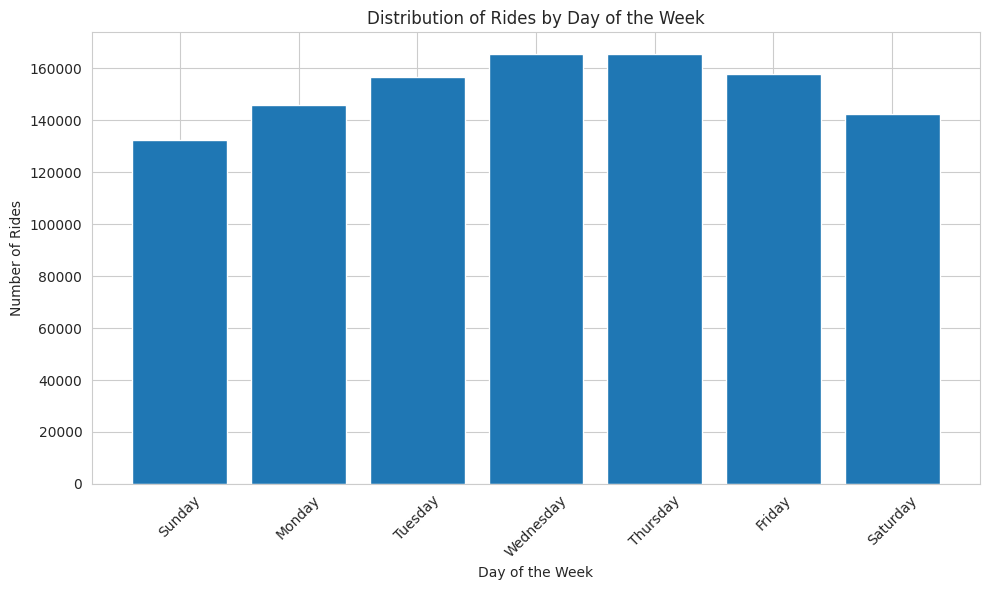

In [21]:
# Extract day of the week from the 'started_at' timestamp (1: Sunday, 2: Monday, ..., 7: Saturday)
objects = objects.withColumn('day_of_week', dayofweek('started_at'))

# Group by day of the week and count the number of rides
ride_days = objects.groupBy('day_of_week').count().orderBy('day_of_week')

# Convert DataFrame to Pandas DataFrame for plotting
ride_days_pd = ride_days.toPandas()

# Define the mapping of day of the week numbers to day names
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Map day of the week numbers to day names for better visualization
ride_days_pd['day_of_week'] = ride_days_pd['day_of_week'].map(day_names)

# Plot distribution of rides by day of the week
plt.figure(figsize=(10, 6))
plt.bar(ride_days_pd['day_of_week'], ride_days_pd['count'])
plt.title('Distribution of Rides by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
objects = objects.withColumn('started_at', date_format(col('started_at'), 'yyyy-MM-dd'))
objects.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- total_ride_duration_seconds: long (nullable = true)
 |-- hour: integer (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [30]:
# Group by 'started_at' and count the rides
df = objects.groupBy('started_at').agg(count('*').alias('trips'))

# Sort the DataFrame by date in ascending order
df = df.orderBy('started_at')

In [31]:
df.show()

+----------+-----+
|started_at|trips|
+----------+-----+
|2023-01-01| 1627|
|2023-01-02| 1663|
|2023-01-03| 1416|
|2023-01-04| 1970|
|2023-01-05| 2037|
|2023-01-06| 1824|
|2023-01-07| 1897|
|2023-01-08| 1470|
|2023-01-09| 1796|
|2023-01-10| 2013|
|2023-01-11| 2022|
|2023-01-12| 1406|
|2023-01-13| 1861|
|2023-01-14| 1449|
|2023-01-15| 1304|
|2023-01-16| 1607|
|2023-01-17| 1932|
|2023-01-18| 2288|
|2023-01-19| 1100|
|2023-01-20| 2092|
+----------+-----+
only showing top 20 rows



In [32]:
df=df.withColumnRenamed('started_at', 'ds').withColumnRenamed('trips', 'y')
df.show()

+----------+----+
|        ds|   y|
+----------+----+
|2023-01-01|1627|
|2023-01-02|1663|
|2023-01-03|1416|
|2023-01-04|1970|
|2023-01-05|2037|
|2023-01-06|1824|
|2023-01-07|1897|
|2023-01-08|1470|
|2023-01-09|1796|
|2023-01-10|2013|
|2023-01-11|2022|
|2023-01-12|1406|
|2023-01-13|1861|
|2023-01-14|1449|
|2023-01-15|1304|
|2023-01-16|1607|
|2023-01-17|1932|
|2023-01-18|2288|
|2023-01-19|1100|
|2023-01-20|2092|
+----------+----+
only showing top 20 rows



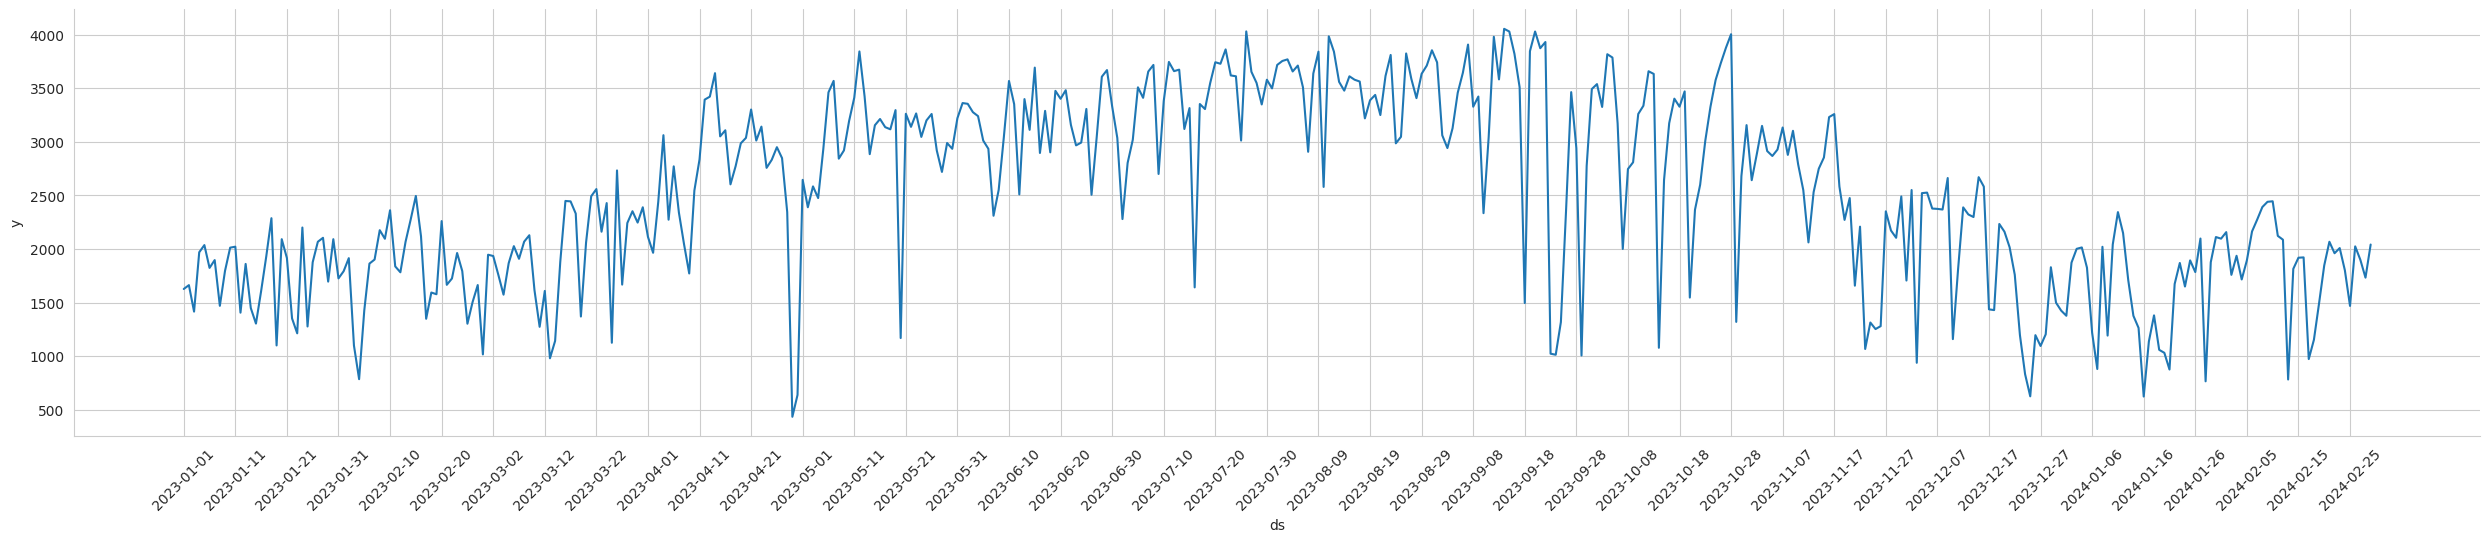

In [33]:
trips_df_pd=df.toPandas()
g = sns.relplot(x="ds", y="y", kind="line", data=trips_df_pd, aspect=5)

# Customize x-axis ticks to display every 10th day
x_ticks = trips_df_pd['ds'][::10]
g.set(xticks=x_ticks)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()
g.fig.autofmt_xdate()

In [34]:
len(trips_df_pd)

425

In [35]:
trips_df_pd['ds'] = pd.to_datetime(trips_df_pd['ds'])

In [36]:
train_data = trips_df_pd[trips_df_pd['ds'].dt.year == 2023]
test_data = trips_df_pd[trips_df_pd['ds'].dt.year == 2024]

In [39]:
train_data.head()

ds     y
0 2023-01-01  1627
1 2023-01-02  1663
2 2023-01-03  1416
3 2023-01-04  1970
4 2023-01-05  2037

In [40]:
train_data.tail()

ds     y
360 2023-12-27  1095
361 2023-12-28  1204
362 2023-12-29  1830
363 2023-12-30  1499
364 2023-12-31  1425

In [41]:
test_data.head()

ds     y
365 2024-01-01  1377
366 2024-01-02  1873
367 2024-01-03  2002
368 2024-01-04  2015
369 2024-01-05  1826

In [42]:
test_data.tail()

ds     y
420 2024-02-25  1469
421 2024-02-26  2025
422 2024-02-27  1900
423 2024-02-28  1733
424 2024-02-29  2042

In [43]:
model=Prophet()
model.fit(train_data)

future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:21 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
forecast.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2023-01-01  1519.280256   536.736803  1877.855182  1519.280256  1519.280256   
1 2023-01-02  1528.969327   714.989853  2099.709478  1528.969327  1528.969327   
2 2023-01-03  1538.658398  1037.891836  2396.281105  1538.658398  1538.658398   
3 2023-01-04  1548.347469  1077.556473  2465.458955  1548.347469  1548.347469   
4 2023-01-05  1558.036539  1036.486466  2429.708909  1558.036539  1558.036539   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -321.674932           -321.674932           -321.674932 -321.674932   
1     -135.894535           -135.894535           -135.894535 -135.894535   
2       98.636887             98.636887             98.636887   98.636887   
3      218.992421            218.992421            218.992421  218.992421   
4      194.252751            194.252751            194.252751  194.252751   

   weekly_lower  weekly_upper  multiplicative_terms  \
0   -321.674932   -321.674932                   0.0   
1   -135.894535   -135.894535                   0.0   
2     98.636887     98.636887                   0.0   
3    218.992421    218.992421                   0.0   
4    194.252751    194.252751                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  1197.605324  
1                         0.0                         0.0  1393.074792  
2                         0.0                         0.0  1637.295284  
3                         0.0                         0.0  1767.339889  
4                         0.0                         0.0  1752.289290

In [45]:
forecast.tail()

ds        trend  yhat_lower   yhat_upper  trend_lower  \
420 2024-02-25  1127.257045  107.206133  1514.878895  1041.786087   
421 2024-02-26  1114.268980  263.640714  1664.099176  1026.492657   
422 2024-02-27  1101.280915  516.697861  1875.688959  1010.845161   
423 2024-02-28  1088.292850  602.708438  2022.070168   995.470617   
424 2024-02-29  1075.304785  562.797257  1998.764798   980.067520   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
420  1222.792760     -321.674932           -321.674932           -321.674932   
421  1211.839182     -135.894535           -135.894535           -135.894535   
422  1202.073839       98.636887             98.636887             98.636887   
423  1193.126402      218.992421            218.992421            218.992421   
424  1182.991196      194.252751            194.252751            194.252751   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
420 -321.674932   -321.674932   -321.674932                   0.0   
421 -135.894535   -135.894535   -135.894535                   0.0   
422   98.636887     98.636887     98.636887                   0.0   
423  218.992421    218.992421    218.992421                   0.0   
424  194.252751    194.252751    194.252751                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
420                         0.0                         0.0   805.582113  
421                         0.0                         0.0   978.374445  
422                         0.0                         0.0  1199.917802  
423                         0.0                         0.0  1307.285271  
424                         0.0                         0.0  1269.557535

In [46]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat  yhat_lower   yhat_upper
420 2024-02-25   805.582113  107.206133  1514.878895
421 2024-02-26   978.374445  263.640714  1664.099176
422 2024-02-27  1199.917802  516.697861  1875.688959
423 2024-02-28  1307.285271  602.708438  2022.070168
424 2024-02-29  1269.557535  562.797257  1998.764798

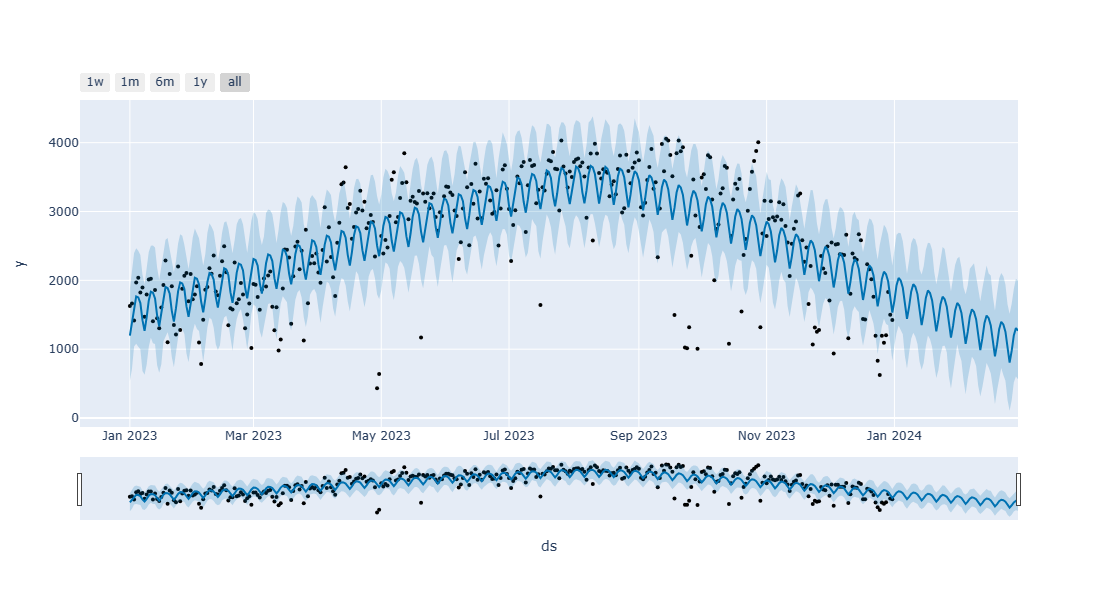

In [47]:
plot_plotly(model ,forecast)

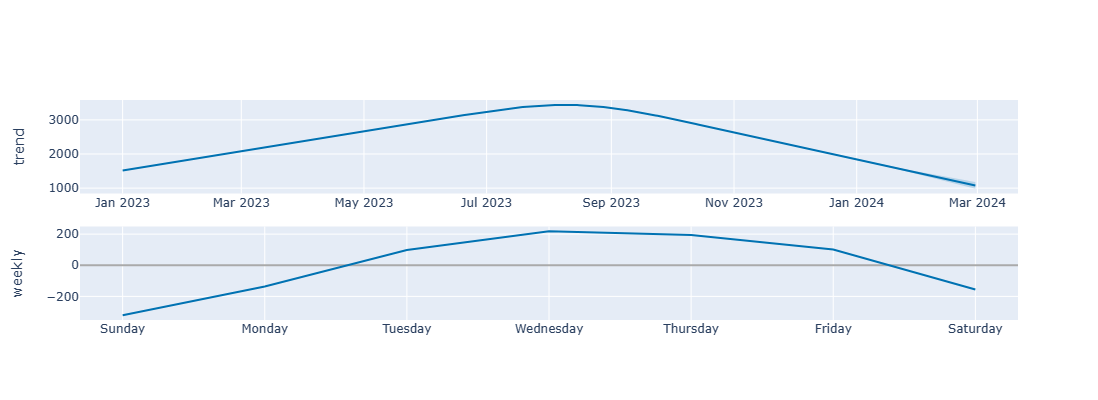

In [48]:
plot_components_plotly(model, forecast)

In [49]:
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

365    1705.706092
366    1927.249448
367    2034.616917
368    1996.889182
369    1891.400198
370    1620.595879
371    1441.997304
372    1614.789636
373    1836.332993
374    1943.700461
375    1905.972726
376    1800.483742
377    1529.679423
378    1351.080848
379    1523.873180
380    1745.416537
381    1852.784006
382    1815.056270
383    1709.567287
384    1438.762967
385    1260.164392
386    1432.956724
387    1654.500081
388    1761.867550
389    1724.139815
390    1618.650831
391    1347.846511
392    1169.247936
393    1342.040268
394    1563.583625
395    1670.951094
396    1633.223359
397    1527.734375
398    1256.930056
399    1078.331480
400    1251.123812
401    1472.667169
402    1580.034638
403    1542.306903
404    1436.817919
405    1166.013600
406     987.415025
407    1160.207357
408    1381.750713
409    1489.118182
410    1451.390447
411    1345.901463
412    1075.097144
413     896.498569
414    1069.290901
415    1290.834257
416    1398.201726
417    1360.

In [50]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 584.3535036620814


In [51]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 503.49706257345474


In [52]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.32100029137527486


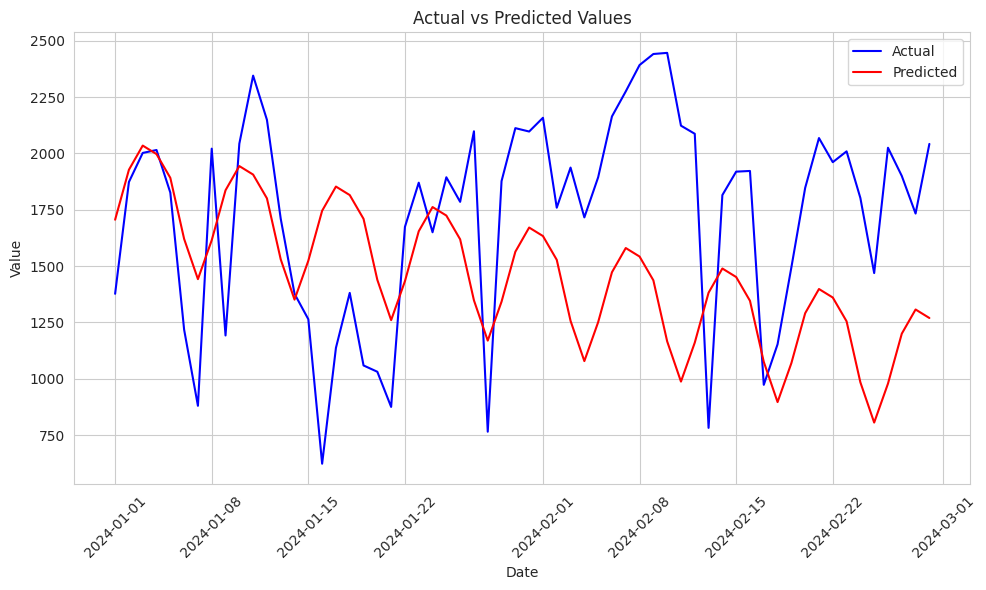

In [53]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values with dates
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Adding Holidays

In [55]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

# Get the holidays for a specific year
holidays = cal.holidays(start='2023-01-01', end='2024-02-25',return_name=True)

# Print the list of holidays
print("US Federal Holidays in 2023:")
print(holidays)

US Federal Holidays in 2023:
2023-01-02                          New Year's Day
2023-01-16     Birthday of Martin Luther King, Jr.
2023-02-20                   Washington's Birthday
2023-05-29                            Memorial Day
2023-06-19    Juneteenth National Independence Day
2023-07-04                        Independence Day
2023-09-04                               Labor Day
2023-10-09                            Columbus Day
2023-11-10                            Veterans Day
2023-11-23                        Thanksgiving Day
2023-12-25                           Christmas Day
2024-01-01                          New Year's Day
2024-01-15     Birthday of Martin Luther King, Jr.
2024-02-19                   Washington's Birthday
dtype: object


In [56]:
holiday_df = pd.DataFrame(data=holidays,columns=['holiday'])

In [57]:
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [58]:
holiday_df

ds                               holiday
0  2023-01-02                        New Year's Day
1  2023-01-16   Birthday of Martin Luther King, Jr.
2  2023-02-20                 Washington's Birthday
3  2023-05-29                          Memorial Day
4  2023-06-19  Juneteenth National Independence Day
5  2023-07-04                      Independence Day
6  2023-09-04                             Labor Day
7  2023-10-09                          Columbus Day
8  2023-11-10                          Veterans Day
9  2023-11-23                      Thanksgiving Day
10 2023-12-25                         Christmas Day
11 2024-01-01                        New Year's Day
12 2024-01-15   Birthday of Martin Luther King, Jr.
13 2024-02-19                 Washington's Birthday

In [59]:
model_with_holiday=Prophet(holidays=holiday_df)
model_with_holiday.fit(train_data)

22:39:53 - cmdstanpy - INFO - Chain [1] start processing
22:39:53 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
future = model_with_holiday.make_future_dataframe(periods=60)
forecast = model_with_holiday.predict(future)

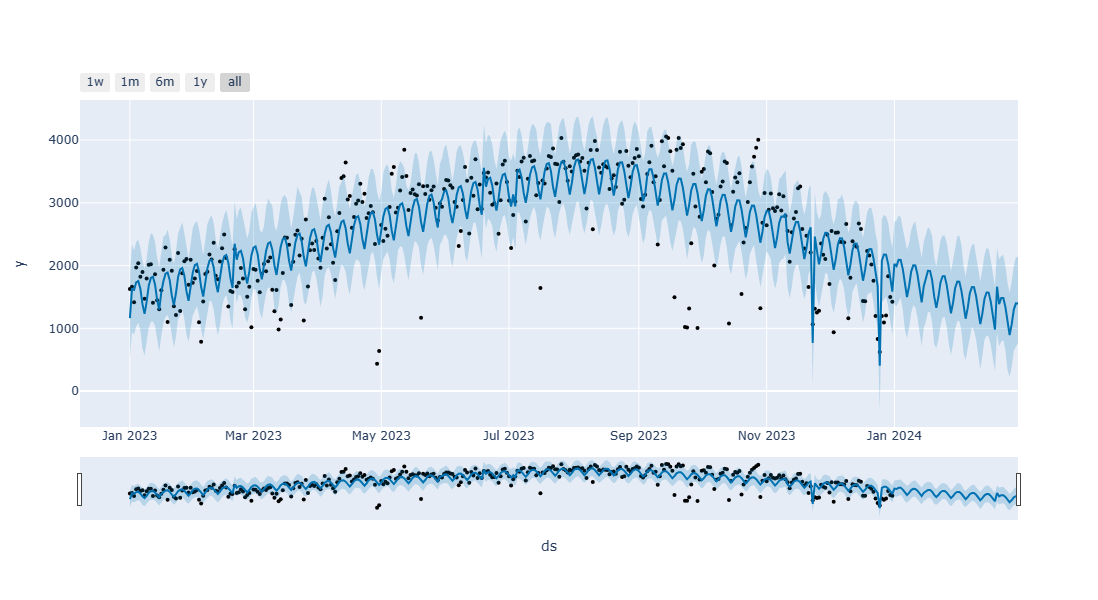

In [61]:
plot_plotly(model_with_holiday ,forecast)

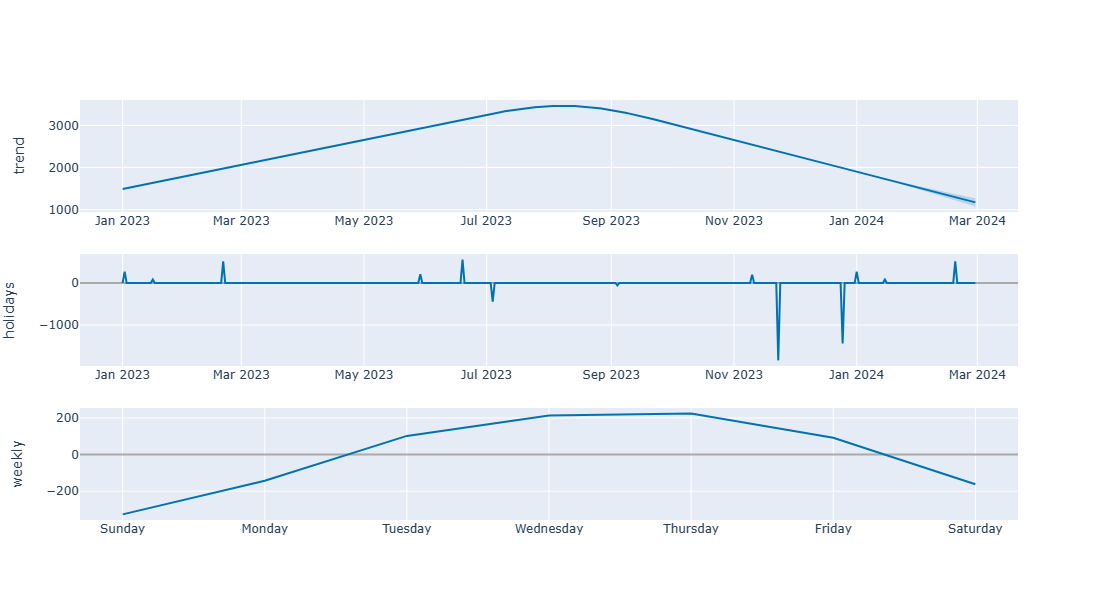

In [62]:
plot_components_plotly(model_with_holiday, forecast)

In [63]:
# predictions = forecast.iloc[-60:]['yhat']
predictions = forecast[forecast['ds'].dt.year == 2024]['yhat']
predictions

365    2027.006738
366    1990.849356
367    2090.136344
368    2088.145954
369    1943.857902
370    1676.863469
371    1499.659380
372    1671.355619
373    1904.368999
374    2003.655987
375    2001.665597
376    1857.377545
377    1590.383112
378    1413.179023
379    1667.160551
380    1817.888642
381    1917.175630
382    1915.185240
383    1770.897188
384    1503.902755
385    1326.698666
386    1498.394906
387    1731.408285
388    1830.695273
389    1828.704883
390    1684.416831
391    1417.422398
392    1240.218310
393    1411.914549
394    1644.927928
395    1744.214916
396    1742.224527
397    1597.936474
398    1330.942041
399    1153.737953
400    1325.434192
401    1558.447571
402    1657.734559
403    1655.744170
404    1511.456117
405    1244.461684
406    1067.257596
407    1238.953835
408    1471.967215
409    1571.254203
410    1569.263813
411    1424.975760
412    1157.981327
413     980.777239
414    1663.225278
415    1385.486858
416    1484.773846
417    1482.

In [64]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true=test_data['y'], y_pred=predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 550.9215952252125


In [65]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=test_data['y'],  y_pred=predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 472.0280887603811


In [66]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true=test_data['y'], y_pred=predictions)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.31372096062109095


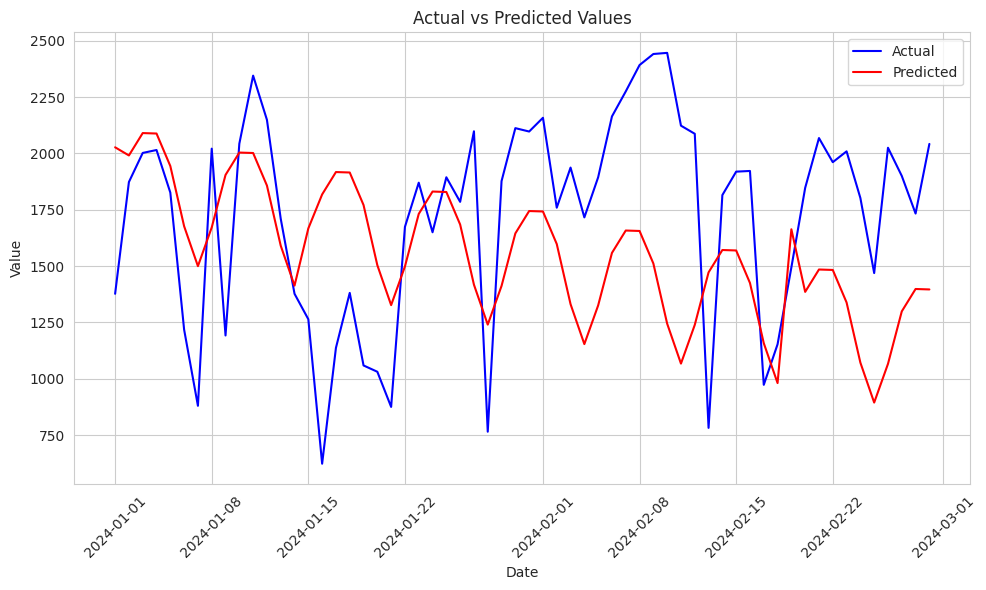

In [67]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values with dates
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
